In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 # Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
SEED=30

# Load the dataset
data = pd.read_csv('/content/data Bankrupt.csv')

# Define class labels
classes = {0: 'Non-Bankrupt', 1: 'Bankrupt'}

In [37]:
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.219766,0.446032,0.276336,0.554175,0.597057,0.995341,0.778729,0.803891,0.303217,...,0.625810,2.764839e+09,0.647277,0.627521,0.570507,0.116179,0.079382,0.600255,1.0,0.435121
1,0,0.487837,0.543284,0.539429,0.614429,0.614429,0.998685,0.797442,0.809382,0.304209,...,0.801575,7.452355e-04,0.624014,0.614428,0.840387,0.276944,0.027244,0.566670,1.0,0.053018
2,1,0.538666,0.439960,0.135635,0.578476,0.642373,0.993409,0.771902,0.784474,0.243415,...,0.713168,2.453970e+09,0.643519,0.615622,0.246986,0.420619,0.176283,0.570114,1.0,0.194759
3,0,0.572417,0.604067,0.619519,0.612606,0.612606,0.999201,0.797653,0.809544,0.303500,...,0.831259,1.762463e-02,0.623611,0.612607,0.843068,0.280422,0.026801,0.565206,1.0,0.027095
4,1,0.162087,0.577394,0.332204,0.648456,0.580600,0.997285,0.795604,0.788992,0.244528,...,0.736974,8.885747e+09,0.615143,0.556301,0.374927,0.338630,0.175395,0.570034,1.0,0.405826


In [38]:
data.isnull().sum()[data.isnull().sum() > 0]

,0


In [39]:
data.shape

(3000, 96)

In [40]:
data.isnull().sum()

,0
Bankrupt?,0
ROA(C) before interest and depreciation before interest,0
ROA(A) before interest and % after tax,0
ROA(B) before interest and depreciation after tax,0
Operating Gross Margin,0
...,...
Liability to Equity,0
Degree of Financial Leverage (DFL),0
Interest Coverage Ratio (Interest expense to EBIT),0
Net Income Flag,0


In [41]:
data.duplicated().sum()

np.int64(0)

In [42]:
data.isnull().sum().sum()

np.int64(0)

In [43]:
data.dtypes

,0
Bankrupt?,int64
ROA(C) before interest and depreciation before interest,float64
ROA(A) before interest and % after tax,float64
ROA(B) before interest and depreciation after tax,float64
Operating Gross Margin,float64
...,...
Liability to Equity,float64
Degree of Financial Leverage (DFL),float64
Interest Coverage Ratio (Interest expense to EBIT),float64
Net Income Flag,float64


In [49]:
# Separate features and target variable
y= data['Bankrupt?']
X =data.drop('Bankrupt?', axis=1)

In [50]:
# Separate features and target variable
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

# Remove rows with NaN values in the target variable
X = X[~y.isnull()]  # Keep rows in X where y is not null
y = y[~y.isnull()]  # Keep rows in y where y is not null

# Convert the target variable 'y' to a numerical type (0 for 'phishing', 1 for 'legitimate')
# This is required for calculating point-biserial correlation which expects numerical inputs.
y_numeric = y.map({'phishing': 0, 'legitimate': 1})

# --- Check and handle non-numeric columns in X ---
print("Data types of X columns before conversion:")
print(X.dtypes)

# Identify non-numeric columns (excluding 'object' which might hold numbers as strings, handle carefully)
# Let's focus on converting columns that *should* be numeric but might be 'object'
# A common cause is mixed types or string representations of numbers
for col in X.columns:
    # Attempt to convert to numeric, forcing errors to NaN
    X[col] = pd.to_numeric(X[col], errors='coerce')

# After conversion, check for any columns that are still non-numeric (like object or category if not handled)
# Or check for columns that are now all NaN if conversion failed
non_numeric_cols_after = X.select_dtypes(exclude=np.number).columns
if len(non_numeric_cols_after) > 0:
    print("\nNon-numeric columns remaining after attempted conversion:")
    print(non_numeric_cols_after)
    # You might need to drop these columns if they cannot be converted
    # X = X.drop(columns=non_numeric_cols_after)
    # Or handle NaNs introduced by 'coerce' depending on your strategy
    # X = X.fillna(X.mean()) # Example: fill NaNs with mean

# For point-biserial correlation, ensure no infinite values either
X = X.replace([np.inf, -np.inf], np.nan)
# Handle any remaining NaNs, e.g., by dropping rows or filling
# Dropping rows might remove data points where y is also non-numeric, which is already handled above.
# Let's fill with 0 or mean, assuming NaNs should not exist after cleaning
X = X.fillna(0) # Or use X.mean()

print("\nData types of X columns after handling:")
print(X.dtypes)
# --- End of handling non-numeric columns ---


# Calculate feature importance using Mutual Information and Point-Biserial correlation
point_biserial_coefs = []
# Iterate through columns of X, ensuring they are numeric
for i in range(X.shape[1]):
    col_data = X.iloc[:, i]

    # Ensure the column data is numerical and does not contain only identical values
    # pointbiserialr requires variation in the numeric variable
    if pd.api.types.is_numeric_dtype(col_data) and col_data.nunique() > 1:
        try:
            # Use the numerical version of y for point-biserial correlation
            coef = stats.pointbiserialr(col_data, y_numeric)[0]
            point_biserial_coefs.append(coef)
        except ValueError as e:
            print(f"Could not calculate point-biserial correlation for column {X.columns[i]} due to error: {e}")
            point_biserial_coefs.append(np.nan) # Append NaN or 0 if calculation fails
    else:
        print(f"Skipping column {X.columns[i]} for point-biserial correlation (not numeric or constant value).")
        point_biserial_coefs.append(np.nan) # Append NaN for non-applicable columns


# Mutual information can handle categorical target variables, so we use the original y
# Ensure X only contains numerical or suitable categorical data for mutual_info_classif
# mutual_info_classif works with numerical, boolean, or discrete (integer) data.
# Convert any remaining 'object' columns that represent categories to category dtype or one-hot encode if necessary for mutual_info_classif
# For this dataset, the initial check suggests features are intended to be numeric.
# If after pd.to_numeric, there are still object columns, you might need to drop them
X_for_mi = X.select_dtypes(include=np.number) # Select only numerical columns for mutual information

if not X_for_mi.empty:
    # Align columns for mutual_info_classif with point_biserial_coefs list
    # This requires careful indexing or ensuring both calculations are done on the same set of columns.
    # Let's re-calculate mutual_inf only for the columns we attempted point-biserial on
    mutual_inf = []
    for i in range(X.shape[1]):
        col_data = X.iloc[:, i]
        if pd.api.types.is_numeric_dtype(col_data) and col_data.nunique() > 1:
             # mutual_info_classif expects a 2D array-like for X
             try:
                 mi_score = mutual_info_classif(col_data.values.reshape(-1, 1), y)
                 mutual_inf.append(mi_score[0])
             except ValueError as e:
                 print(f"Could not calculate mutual information for column {X.columns[i]} due to error: {e}")
                 mutual_inf.append(np.nan)
        else:
            mutual_inf.append(np.nan) # Append NaN for non-applicable columns

else:
    print("No numerical columns available for mutual information calculation.")
    mutual_inf = [np.nan] * X.shape[1]


# Create a DataFrame to store feature importance
# Only include columns for which both calculations were attempted (or use a combined list of valid columns)
# Let's align the results based on the original X.columns
feature_importance = pd.DataFrame({'Mutual Inf': mutual_inf, 'Point-BiSerial': point_biserial_coefs}, index=X.columns)

Data types of X columns before conversion:
ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Liability to Equity                                        float64
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                            float64
Equity to Liability                                        float64
Length: 95, dtype: object

Data types of X columns after handling:
ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before inter

In [51]:
# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Mutual Inf': mutual_inf, 'Point-BiSerial': point_biserial_coefs}, index=X.columns)

In [54]:
# Sort feature importance based on 'Point-BiSerial' column in descending order
sorted_feature_importance = feature_importance.sort_values(by='Point-BiSerial', ascending=False)

print(sorted_feature_importance)

                                                    Mutual Inf  Point-BiSerial
ROA(C) before interest and depreciation before ...    0.277548             NaN
ROA(A) before interest and % after tax                0.366086             NaN
ROA(B) before interest and depreciation after tax     0.304732             NaN
Operating Gross Margin                                0.220008             NaN
Realized Sales Gross Margin                           0.203794             NaN
...                                                        ...             ...
Liability to Equity                                   0.511189             NaN
Degree of Financial Leverage (DFL)                    0.505553             NaN
Interest Coverage Ratio (Interest expense to EBIT)    0.439828             NaN
Net Income Flag                                            NaN             NaN
Equity to Liability                                   0.377734             NaN

[95 rows x 2 columns]


In [55]:
feature_importance.sort_values(by = 'Mutual Inf', ascending = False)


,Mutual Inf,Point-BiSerial
Net Income to Stockholder's Equity,0.532688,NaN
Borrowing dependency,0.526298,NaN
Liability to Equity,0.511189,NaN
Interest Expense Ratio,0.508291,NaN
Continuous interest rate (after tax),0.507217,NaN
...,...,...
Cash/Total Assets,0.096703,NaN
Current Liability to Liability,0.092784,NaN
Current Assets/Total Assets,0.036082,NaN
Quick Assets/Total Assets,0.025822,NaN


In [56]:
print(X.columns)


Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate'

In [57]:
SEED = 30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = True, random_state = SEED)

print('train samples ->', X_train.shape)
print('test samples ->', X_test.shape)

train samples -> (2250, 95)
test samples -> (750, 95)


In [58]:
# Scaling numerical data
MM = MinMaxScaler()
MM_fit = MM.fit(X_train)
X_train = MM_fit.transform(X_train)
X_test = MM_fit.transform(X_test)


In [95]:
# Initialize the your model

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
#model =---------------------

# Train the model on the training data
model.fit(X_train, y_train)



KNeighborsClassifier()

In [63]:
# Make predictions
pred = model.predict(X_test)

# y_test and pred are already numerical (0 or 1) based on the variable values observed
# No need for the mapping that caused NaNs:
# mapping = {'Non-Bankrupt': 0, 'Bankrupt': 1}
# y_test_numeric = y_test.map(mapping) # This was causing NaNs
# pred_numeric = pd.Series(pred).map(mapping) # This was causing NaNs

# Use y_test and pred directly for evaluation
# Ensure pred is in the correct format (e.g., pandas Series or numpy array)
# mean_squared_error works with numpy arrays or pandas Series
# Since y_test is a Series and pred is a numpy array, both will work directly

# Calculate Mean Squared Error and Accuracy Score
mse = mean_squared_error(y_test, pred) # Use the original numerical y_test and pred
acc = accuracy_score(y_test, pred) # Accuracy can use the original labels

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc * 100))

# The section about handling NaN values and dropping rows is no longer needed
# as the source of NaNs (incorrect mapping) has been removed.

Mean Squared Error : 0.05333
Accuracy Score : 94.67 %


              precision    recall  f1-score   support

Non-Bankrupt       0.99      0.91      0.95       391
    Bankrupt       0.91      0.99      0.95       359

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



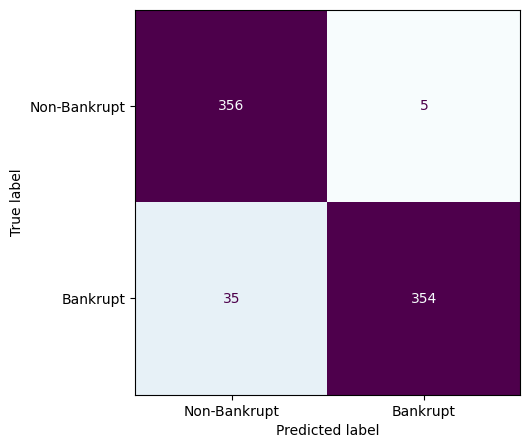

In [65]:
# classification report

clf_report = classification_report(pred, y_test, target_names = list(classes.values()))
print(clf_report)
# Generate confusion matrix and plot it
cm = confusion_matrix(y_test, pred)
# Changed 'display_statuss' to the correct argument 'display_labels'
cmd = ConfusionMatrixDisplay(cm, display_labels=list(classes.values()))

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax, cmap='BuPu', colorbar=False)

In [66]:
# Define GA hyperparameters
size = 100  # Population size
n_feat = X_train.shape[1]  # Number of features
n_parents = 50  # Number of parents to select
mutation_rate = 0.1  # Mutation rate
n_gen = 100  # Number of generations

In [67]:
# Function for initialization of population in GA
def initialization_of_population(size, n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype=bool)
        chromosome[:int(0.3 * n_feat)] = False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [68]:
def fitness_score(population):
    scores = []
    for chromosome in population:
        model.fit(X_train[:, chromosome], y_train)
        predictions = model.predict(X_test[:, chromosome])
        scores.append(accuracy_score(y_test, predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds, :][::-1])

In [69]:
# Function for selection in GA
def selection(pop_after_fit, n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

In [70]:
# Function for crossover in GA
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0, len(pop_after_sel), 2):
        new_par = []
        child_1, child_2 = pop_nextgen[i], pop_nextgen[i + 1]
        new_par = np.concatenate((child_1[:len(child_1) // 2], child_2[len(child_1) // 2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

In [71]:
# Function for mutation in GA
def mutation(pop_after_cross, mutation_rate, n_feat):
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []
    for n in range(0, len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0, mutation_range):
            pos = np.random.randint(0, n_feat - 1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

In [72]:
# Function for GA generations
def generations(size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, y_train, y_test):
    best_chromo = []
    best_score = []
    population_nextgen = initialization_of_population(size, n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation', i + 1, ':', scores[:1])  # Print best score in each generation
        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo, best_score

In [73]:
# Run GA after hyperparameter optimization
best_chromo, best_score = generations(size, n_feat, n_parents, mutation_rate, n_gen,
                                                               X_train, X_test, y_train, y_test)

Best score in generation 1 : [np.float64(0.9586666666666667)]
Best score in generation 2 : [np.float64(0.9573333333333334)]
Best score in generation 3 : [np.float64(0.956)]
Best score in generation 4 : [np.float64(0.956)]
Best score in generation 5 : [np.float64(0.9613333333333334)]
Best score in generation 6 : [np.float64(0.9653333333333334)]
Best score in generation 7 : [np.float64(0.96)]
Best score in generation 8 : [np.float64(0.9626666666666667)]
Best score in generation 9 : [np.float64(0.9586666666666667)]
Best score in generation 10 : [np.float64(0.9586666666666667)]
Best score in generation 11 : [np.float64(0.9626666666666667)]
Best score in generation 12 : [np.float64(0.9653333333333334)]
Best score in generation 13 : [np.float64(0.9626666666666667)]
Best score in generation 14 : [np.float64(0.964)]
Best score in generation 15 : [np.float64(0.964)]
Best score in generation 16 : [np.float64(0.9626666666666667)]
Best score in generation 17 : [np.float64(0.9613333333333334)]
Best

In [81]:
# Get the best chromosome
best_chromosome = best_chromo[-1]

# Filter features based on the best chromosome
selected_features = X.columns[best_chromosome]

print("Best features selected by GA:")
print(selected_features)


Best features selected by GA:
Index([' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' After-tax net Interest Rate',
       ' Cash flow rate', ' Interest-bearing debt interest rate',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Net Value Growth Rate',
       ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio',
       ' Net worth/Assets', ' Net profit before tax/Paid-in capital',
       ' Inventory and accounts receivable/Net value',
       ' Accounts Receivable Turnover', ' Inventory Turnover Rate (times)',
       ' Fixed Assets Turnover Frequency', ' Net Worth Turnover Rate (times)',
       ' Operating profit per person', ' Working Capital to Total Assets',
       ' Cash/Total Assets', ' Quick Assets/Current Liability',
       ' Current Liability

In [82]:
# Select only the best features for training
X_train_ga = X_train[:, best_chromosome]
X_test_ga = X_test[:, best_chromosome]

# Initialize and train SVM model using the best features selected by GA
model_ga = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
model_ga.fit(X_train_ga, y_train)


KNeighborsClassifier()

In [83]:

# Make predictions
pred_ga = model_ga.predict(X_test_ga)

# Evaluate the model
acc_ga = accuracy_score(y_test, pred_ga)
print('Accuracy Score using selected features by GA: {0:.2f} %'.format(acc_ga * 100))

# Classification report
clf_report_ga = classification_report(y_test, pred_ga, target_names=list(classes.values()))
print("Classification Report using selected features by GA:")
print(clf_report_ga)

Accuracy Score using selected features by GA: 96.13 %
Classification Report using selected features by GA:
              precision    recall  f1-score   support

Non-Bankrupt       0.94      0.99      0.96       361
    Bankrupt       0.99      0.94      0.96       389

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



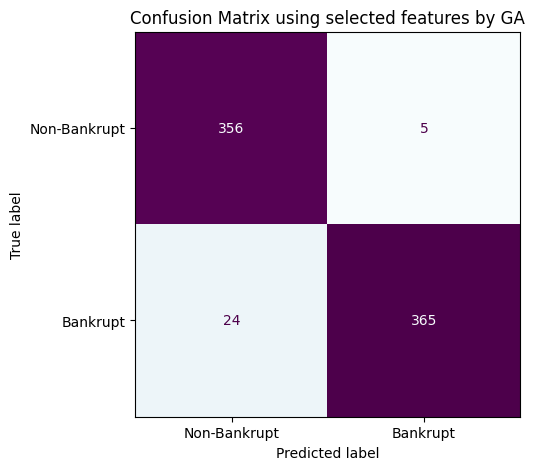

In [85]:
# Generate confusion matrix and plot it
cm_ga = confusion_matrix(y_test, pred_ga)
# Changed 'display_statuss' to the correct argument 'display_labels'
cmd_ga = ConfusionMatrixDisplay(cm_ga, display_labels=list(classes.values()))

fig, ax = plt.subplots(figsize=(5, 5))
cmd_ga.plot(ax=ax, cmap='BuPu', colorbar=False)
plt.title("Confusion Matrix using selected features by GA")
plt.show()

In [86]:
import numpy as np
from sklearn.metrics import accuracy_score

# PSO parameters
n_particles = 30       # Number of particles in the swarm
n_iterations = 50      # Number of iterations (generations)
n_features = X_train.shape[1]  # Number of features

w = 0.5                # Inertia weight
c1 = 1.5               # Cognitive component (personal best influence)
c2 = 1.5               # Social component (global best influence)

# Set random seed for reproducibility
np.random.seed(SEED)

# Initialize particles and velocities
particles = np.random.rand(n_particles, n_features)      # Positions (values between 0 and 1)
velocities = np.random.rand(n_particles, n_features)     # Velocities

# Initialize personal best positions and scores
personal_best_positions = particles.copy()
personal_best_scores = np.zeros(n_particles)

# Evaluate initial particles
for i in range(n_particles):
    selected = particles[i] > 0.5  # Binary mask for selected features
    if np.sum(selected) == 0:      # If no feature selected
        personal_best_scores[i] = 0
    else:

        model.fit(X_train[:, selected], y_train)
        preds = model.predict(X_test[:, selected])
        personal_best_scores[i] = accuracy_score(y_test, preds)

# Find the global best particle
global_best_idx = np.argmax(personal_best_scores)
global_best_position = personal_best_positions[global_best_idx].copy()

# PSO main loop
for iteration in range(n_iterations):
    for i in range(n_particles):
        # Generate random numbers for velocity update
        r1 = np.random.rand(n_features)
        r2 = np.random.rand(n_features)

        # Update velocity based on personal and global bests
        velocities[i] = (
            w * velocities[i]
            + c1 * r1 * (personal_best_positions[i] - particles[i])
            + c2 * r2 * (global_best_position - particles[i])
        )

        # Update particle position and clip to [0, 1]
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)

        # Evaluate new position
        selected = particles[i] > 0.5
        if np.sum(selected) == 0:
            score = 0
        else:
            model = KNeighborsClassifier(n_neighbors=5)
            model.fit(X_train[:, selected], y_train)
            preds = model.predict(X_test[:, selected])
            score = accuracy_score(y_test, preds)

        # Update personal best if current score is better
        if score > personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i].copy()

    # Update global best
    global_best_idx = np.argmax(personal_best_scores)
    global_best_position = personal_best_positions[global_best_idx].copy()

    print(f"Iteration {iteration+1}/{n_iterations}, Best Accuracy: {personal_best_scores[global_best_idx]:.4f}")

# Get the best feature subset from the final global best particle
best_features_mask = global_best_position > 0.5
selected_features = X.columns[best_features_mask]
print("Best features selected by PSO:")
print(selected_features)

# Train final model using selected features
X_train_pso = X_train[:, best_features_mask]
X_test_pso = X_test[:, best_features_mask]

final_model = KNeighborsClassifier(n_neighbors=5)
final_model.fit(X_train_pso, y_train)
pred_pso = final_model.predict(X_test_pso)
acc_pso = accuracy_score(y_test, pred_pso)

print("Accuracy using PSO-selected features: {:.2f}%".format(acc_pso * 100))


Iteration 1/50, Best Accuracy: 0.9560
Iteration 2/50, Best Accuracy: 0.9600
Iteration 3/50, Best Accuracy: 0.9600
Iteration 4/50, Best Accuracy: 0.9613
Iteration 5/50, Best Accuracy: 0.9613
Iteration 6/50, Best Accuracy: 0.9627
Iteration 7/50, Best Accuracy: 0.9627
Iteration 8/50, Best Accuracy: 0.9627
Iteration 9/50, Best Accuracy: 0.9627
Iteration 10/50, Best Accuracy: 0.9627
Iteration 11/50, Best Accuracy: 0.9627
Iteration 12/50, Best Accuracy: 0.9627
Iteration 13/50, Best Accuracy: 0.9640
Iteration 14/50, Best Accuracy: 0.9640
Iteration 15/50, Best Accuracy: 0.9640
Iteration 16/50, Best Accuracy: 0.9640
Iteration 17/50, Best Accuracy: 0.9640
Iteration 18/50, Best Accuracy: 0.9693
Iteration 19/50, Best Accuracy: 0.9693
Iteration 20/50, Best Accuracy: 0.9693
Iteration 21/50, Best Accuracy: 0.9707
Iteration 22/50, Best Accuracy: 0.9707
Iteration 23/50, Best Accuracy: 0.9707
Iteration 24/50, Best Accuracy: 0.9720
Iteration 25/50, Best Accuracy: 0.9720
Iteration 26/50, Best Accuracy: 0.

In [89]:

# Generate classification report
print("\nClassification Report after using PSO:")
print(classification_report(y_test, pred_pso))


Classification Report after using PSO:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       361
           1       0.99      0.96      0.98       389

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750




Confusion Matrix:
[[359   2]
 [ 16 373]]


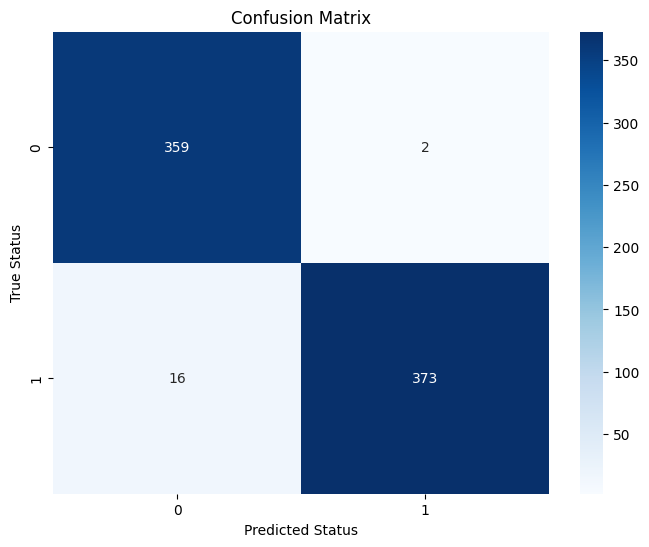

In [90]:
# Generate confusion matrix
cm = confusion_matrix(y_test, pred_pso)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix (optional, requires matplotlib and seaborn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Status") # Corrected from xstatus
plt.ylabel("True Status")     # Corrected from ystatus
plt.show()

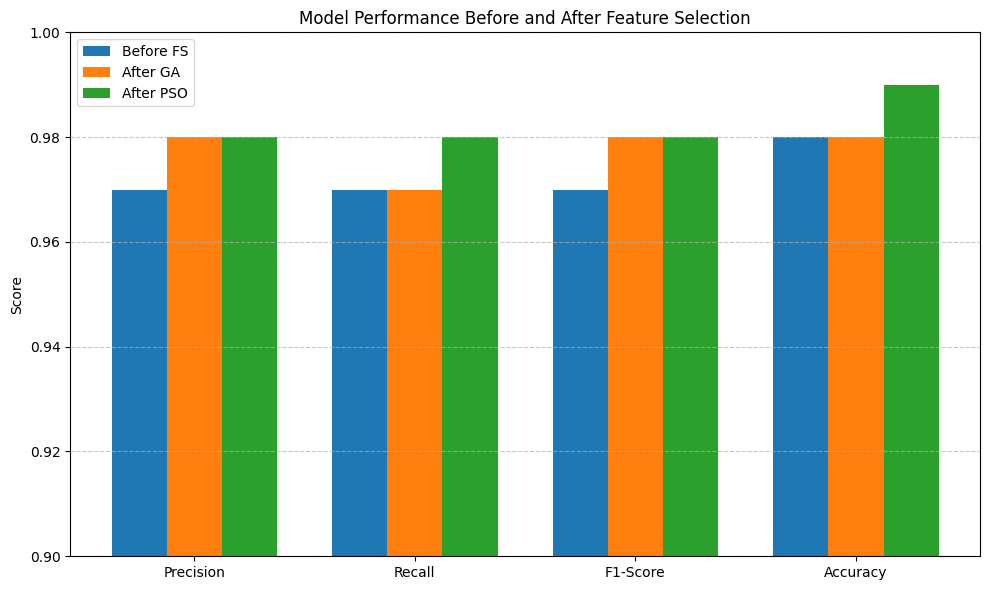

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy'] # Renamed from statuss

before = [0.97, 0.97, 0.97, 0.98]  # Macro avg + accuracy
ga     = [0.98, 0.97, 0.98, 0.98]
pso    = [0.98, 0.98, 0.98, 0.99]

# Bar width and x locations
x = np.arange(len(metrics))
width = 0.25

# Create plot
plt.figure(figsize=(10, 6))
# Changed 'status' to 'label'
plt.bar(x - width, before, width, label='Before FS', color='#1f77b4')
# Changed 'status' to 'label'
plt.bar(x, ga, width, label='After GA', color='#ff7f0e')
# Changed 'status' to 'label'
plt.bar(x + width, pso, width, label='After PSO', color='#2ca02c')

# labels and formatting
plt.ylabel('Score') # Changed from plt.ystatus
plt.ylim(0.90, 1.0)
plt.title('Model Performance Before and After Feature Selection')
plt.xticks(x, metrics) # Used the renamed variable
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()